# Balbúrdia Model 

## Modified SEIR model for the COVID-19


                                                            Marcus Vinicius Costa Duarte - 21/03/2020
                                                            mvcduarte@gmail.com

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.pyplot import cm

%matplotlib inline

As the COVID-19 (Corona virus) pandemic is considered a quite serious episode in the beginning of 2020, the social distancing becomes crucial to stop the outbreaks. Here, I used an epidemic mathematical model called SEIR, commonly used to model the spread of other diseases (such as meales, small pots, etc) to predict the outbreak of COVID 19 and how to use the social distancing to stop or minimize its dramatic effects.   

## 1 - Modified SEIR Model

The classical SEIR model is composed by the following groups/populations:

**Suscetible (S)**: fraction of the population which is susceptible to get the disease.


**Exposed (E)**: fraction of the population which is infected but no symptoms.


**Infected (I)**: fraction of the population which is infected.


**Recovered (R)**: fraction of the population which is recovered by the disease.

Here, we include the fraction of the population that is isolated in quarantine **Q(t)** and the death rate **D(t)**. Note that the sum of all groups should be conserved since this model does not have incoming/outgoing people flux or vital dynamics. Mathematically, the model can be written by a set of coupled ordinary differential equation (ODE):
<br/><br/>
<font size="5">
$\dot{S}(t) = -\beta S(t) I(t)$

$\dot{E}(t) = -\beta S(t) I(t) - \alpha E(t)$

$\dot{I}(t) = \alpha E(t) - \gamma I(t)$

$\dot{R}(t) = \gamma I(t)$

$\dot{Q}(t) = \delta I(t) - \lambda Q(t) - \kappa Q(t)$

$\dot{D}(t) = \kappa Q(t)$

</font>
<br/><br/>

The SEIR model depends on some uncertain parameters up to now that is highly linked to disease characteristics. 

$\alpha^{-1}$: mean incubation time

$\beta$: average number of contacts per person per time

$\gamma^{-1}$: mean infection time

$\delta^{-1}$: mean time in quarentine

$\lambda$: cure rate

$\kappa$: mortality rate

There is an important parameter for epidemic episodes, the basic reprodutive number ($R_0$). It is a good indicator to show if the disease is controlled ($R_0<1$) or grows in exponencial behavior ($R_0>1$). This parameter is defined as $R_0=\beta / \gamma$, being the ratio between the average number of contact times the mean infection period ($t_{infection} = \gamma^{-1}$).

The cure and mortality rates ($\lambda$ and $\kappa$) are time-dependent, however, we consider them constant and 0.06 and 0.01, respectively (see https://arxiv.org/pdf/2002.06563.pdf). In the future, this model can be improved using time-dependent functions since there will be more data.

In order to solve the aforementioned ODE system, the 4-th order Runge Kutta method is employed.  

In [2]:
# Let us define some functions before start running...

# Runge Kutta 4th order 

def fS(S, I, beta): 
    return - beta * S * I
def fE(S, I, E, alpha, beta): 
    return beta * S * I - alpha * E
def fI(I, alpha, gamma, E): 
    return alpha * E - gamma * I
def fQ(delta, I, Q, lambda0, kappa):
    return delta * I - lambda0 * Q - kappa * Q
def fR(lambda0, I):
    return lambda0 * I
def fD(Q, kappa):
    return kappa * Q

def base_seir_model_RK4O(init_vals, params, t):
    
    S_0, E_0, I_0, R_0, Q_0, D_0 = init_vals
    S, E, I, R, Q, D = [S_0], [E_0], [I_0], [R_0], [Q_0], [D_0]
    alpha, beta_array, gamma, delta, lambda0, kappa = params
    dt = t[1] - t[0]
    for i in range(len(t)-1):
        
        # 4-th order Runge Kutta
        
        k1 = fS(S[-1], I[-1], beta_array[i])
        l1 = fE(S[-1], I[-1], E[-1], alpha, beta_array[i])
        m1 = fI(I[-1], alpha, gamma, E[-1])
        n1 = fR(lambda0, I[-1])
        o1 = fQ(delta, I[-1], Q[-1], lambda0, kappa)
        p1 = fD(Q[-1], kappa)

        k2 = fS(S[-1] + 0.5 * k1 * dt, I[-1] + 0.5 * m1 * dt, beta_array[i])
        l2 = fE(S[-1] + 0.5 * k1 * dt, I[-1] + 0.5 * m1 * dt, E[-1] + 0.5 * l1 * dt, alpha, beta_array[i])
        m2 = fI(I[-1] + 0.5 * m1 * dt, alpha, gamma, E[-1] + 0.5 * l1 * dt)
        n2 = fR(lambda0, I[-1] + 0.5 * m1 * dt)
        o2 = fQ(delta, I[-1] + 0.5 * m1 * dt, Q[-1] + 0.5 * o1 * dt, lambda0, kappa)
        p2 = fD(Q[-1] + 0.5 * p1 * dt, kappa)

        k3 = fS(S[-1] + 0.5 * k2 * dt, I[-1] + 0.5 * m2 * dt, beta_array[i])
        l3 = fE(S[-1] + 0.5 * k2 * dt, I[-1] + 0.5 * m2 * dt, E[-1] + 0.5 * l2 * dt, alpha, beta_array[i])
        m3 = fI(I[-1] + 0.5 * m2 * dt, alpha, gamma, E[-1] + 0.5 * l2 * dt)
        n3 = fR(lambda0, I[-1] + 0.5 * m2 * dt)
        o3 = fQ(delta, I[-1] + 0.5 * m2 * dt, Q[-1] + 0.5 * o2 * dt, lambda0, kappa)
        p3 = fD(Q[-1] + 0.5 * p2 * dt, kappa)

        k4 = fS(S[-1] + k3 * dt, I[-1] + m3 * dt, beta_array[i])
        l4 = fE(S[-1] + k3 * dt, I[-1] + m3 * dt, E[-1] + l3 * dt, alpha, beta_array[i])
        m4 = fI(I[-1] + m3 * dt, alpha, gamma, E[-1] + m3 * dt)
        n4 = fR(lambda0, I[-1] + n3 * dt)
        o4 = fQ(delta, I[-1] + m3 * dt, Q[-1] + o3 * dt, lambda0, kappa)
        p4 = fD(Q[-1] + p3 * dt, kappa)

        # Calculate next timestep value 
        
        next_S = S[-1] + (1. / 6.) * (k1 + 2. * (k2 + k3) + k4) * dt
        next_E = E[-1] + (1. / 6.) * (l1 + 2. * (l2 + l3) + l4) * dt
        next_I = I[-1] + (1. / 6.) * (m1 + 2. * (m2 + m3) + m4) * dt
        next_R = R[-1] + (1. / 6.) * (n1 + 2. * (n2 + n3) + n4) * dt
        next_Q = Q[-1] + (1. / 6.) * (o1 + 2. * (o2 + o3) + o4) * dt
        next_D = D[-1] + (1. / 6.) * (p1 + 2. * (p2 + p3) + p4) * dt

        sum_all = next_S + next_E + next_I + next_R + next_Q + next_D
        S.append(next_S / sum_all)
        E.append(next_E / sum_all)
        I.append(next_I / sum_all)
        R.append(next_R / sum_all)
        Q.append(next_Q / sum_all)        
        D.append(next_D / sum_all)

    return np.stack([S, E, I, R, Q, D]).T

def get_matrices_results(dic_results, t, niter, percentile):
    
    matrix = np.zeros(len(t) * 6).reshape(6, len(t))
    for i_param in range(6):
        for i in range(len(t)):
            array_tmp = np.zeros(niter)
            for i_iter in range(niter):                
                array_tmp[i_iter] = dic_results[i_iter][i][i_param]

            matrix[i_param, i] = np.log10(np.percentile(array_tmp, percentile) + 1e-9)
        
    return matrix

def plot_fig_model(dic_matrix, title, t0, outfile):

    fig = plt.figure(figsize=(15, 8))
    fig.suptitle(title, fontsize = 20, fontweight = 'bold')
    ax = fig.add_subplot(111)

    # Suscetible
    
    plt.fill_between(t, dic_matrix['p1'][0], dic_matrix['p2'][0], facecolor='blue', alpha = 0.2)
    plt.plot(t, dic_matrix['med'][0], label = 'Suscetible', color = 'blue', lw = 2.)

    # Infected 
    
    plt.fill_between(t, dic_matrix['p1'][2], dic_matrix['p2'][2], facecolor='orange', alpha = 0.2)
    plt.plot(t, dic_matrix['med'][2], label = 'Infected', color = 'orange', lw = 2.)

    # Recovered
    
    plt.fill_between(t, dic_matrix['p1'][3], dic_matrix['p2'][3], facecolor='green', alpha = 0.2)
    plt.plot(t, dic_matrix['med'][3], label = 'Recovered', color = 'green', lw = 2.)

    # Deaths
    
    plt.fill_between(t, dic_matrix['p1'][5], dic_matrix['p2'][5], facecolor='red', alpha = 0.2)
    plt.plot(t, dic_matrix['med'][5], label = 'Death', color = 'red', lw = 2.)

    plt.axvline(x = t0, color = 'black', linestyle='--')

    str_death = "%.2f" % (100. * (10**max(dic_matrix['med'][5])))
    str_infected = "%.2f" % (100. * (10**max(dic_matrix['med'][2])))
    ax.text(0.01, 0.6, 'Acc. Deaths(%):' + str_death + '%', fontsize = 20, transform = ax.transAxes)
    ax.text(0.01, 0.5, 'Peak Infected(%):' + str_infected + '%', fontsize = 20, transform = ax.transAxes)

    plt.xlim([0., max(t)])
    plt.ylim([-2.5, 0.])
    plt.grid()
    plt.xlabel('days', fontsize = 20)
    plt.ylabel('log10(Pop. Fraction)', fontsize = 20)
    plt.legend(fontsize = 20, loc = 4)
    plt.savefig(outfile, bbox_inches = 'tight')
    plt.show()

def plot_fig_model_comparison(dic_model1, dic_model2, title, str_model1, str_model2, t0, frac, outfile):

    fig = plt.figure(figsize=(15, 8))
    fig.suptitle(title, fontsize = 20, fontweight = 'bold')
    ax = fig.add_subplot(111)

    # Infected model1
    
    plt.fill_between(t, dic_model1['p1'][2], dic_model1['p2'][2], facecolor='orange', alpha = 0.2)
    plt.plot(t, dic_model1['med'][2], label = 'Infected - ' + str_model1, color = 'orange', lw = 2.)

    # Death model1
    
    plt.fill_between(t, dic_model1['p1'][5], dic_model1['p2'][5], facecolor='red', alpha = 0.2)
    plt.plot(t, dic_model1['med'][5], label = 'Death - ' + str_model1, color = 'red', lw = 2.)

    # Infected model2
    
    plt.fill_between(t, dic_model2['p1'][2], dic_model2['p2'][2], facecolor='black', alpha = 0.2)
    plt.plot(t, dic_model2['med'][2], label = 'Infected - ' + str_model2, color = 'black', lw = 2.)

    # Death model2
    
    plt.fill_between(t, dic_model2['p1'][5], dic_model2['p2'][5], facecolor='blue', alpha = 0.2)
    plt.plot(t, dic_model2['med'][5], label = 'Death - ' + str_model2, color = 'blue', lw = 2.)

    str_death_sim1 = "%.2f" % (100 * (10**max(dic_model1['med'][5])))
    str_infected_sim1 = "%.2f" % (100. * (10**max(dic_model1['med'][2])))
    str_death_sim2 = "%.2f" % (100. * (10**max(dic_model2['med'][5])))
    str_infected_sim2 = "%.2f" % (100. * (10**max(dic_model2['med'][2])))

    ax.text(0.005, 0.9, 'Acc. Deaths - ' + str_model1 + ':' + str_death_sim1 + '%', fontsize = 12, transform = ax.transAxes)
    ax.text(0.005, 0.85, 'Peak Infected - ' + str_model1 + ':' + str_infected_sim1 + '%', fontsize = 12,transform = ax.transAxes )

    ax.text(0.005, 0.8, 'Acc. Deaths - ' + str_model2 + ':' + str_death_sim2 + '%', fontsize = 12, transform = ax.transAxes)
    ax.text(0.005, 0.75, 'Peak Infected - ' + str_model2 + ':' + str_infected_sim2 + '%', fontsize = 12, transform = ax.transAxes)

    plt.axvline(x = t0, color = 'black', linestyle='--')

    plt.xlim([0., max(t)])
    plt.ylim([-2.5, -0.5])
    plt.grid()
    plt.xlabel('days', fontsize = 20)
    plt.ylabel('log10(Pop. Fraction)', fontsize = 20)
    plt.legend(fontsize = 15, loc = 4)
    plt.savefig(outfile, bbox_inches = 'tight')
    plt.show()
    
    
def step_func(t, t0, frac):
    
    array = np.ones(len(t))
    idx = np.where(t >= t0)
    array[idx] = frac

    return array

def create_param_space(params, range_params, n):
    
    param_array = []
    for i in range(n):
        param_array.append([np.random.normal(range_params[j][0], range_params[j][1], 1)[0] for j in range(len(params))])
    return param_array

def run_simulations(param_array, init_vals, t, niter, type_soc_dist, t0, frac_beta, deltat):

    dic_results = {}
    for i in tqdm(range(niter)):

        if type_soc_dist == 'None': # NO soc_dist -> beta constant over time

            params = param_array[i][0], param_array[i][1] * np.ones(len(t)), \
                     param_array[i][2], param_array[i][3], \
                     param_array[i][4], param_array[i][5]
            
        if type_soc_dist == 'step': # soc_dist takes long time (up to the end of simulation) ...

            step_time = step_func(t, t0, frac_beta)
            
            params = param_array[i][0], param_array[i][1] * step_time, \
                     param_array[i][2], param_array[i][3], \
                     param_array[i][4], param_array[i][5]

        dic_results[i] = base_seir_model_RK4O(init_vals, params, t)
        
    matrix_p1 = get_matrices_results(dic_results, t, niter, 20.) # 20-th percentile
    matrix_med = get_matrices_results(dic_results, t, niter, 50.) # median
    matrix_p2 = get_matrices_results(dic_results, t, niter, 80.) # 80-th percentile
    dic_model = {'p1': matrix_p1, 'p2': matrix_p2, 'med': matrix_med}
        
    return dic_model

## 2 - Model parameters

We present the results of the SEIR model for an initial population of $12\times10^6$ people and the number of infected is 214 in the beginning of the simulation. The goal is to model a large city, such as São Paulo - Brazil, but it can be adapted to other regions with different weather and populations. 

In [3]:
# Define parameters

t_max = 360                                                 # number of days 
dt = .1                                                     # timestep
N = 12e6                                                    # population
t = np.linspace(0, t_max, int(t_max/dt) + 1)                # time array
n_infected = 214                                            # Initial number of infected (18/03/2020 @ Sao Paulo)
init_vals = 1 - n_infected / N, n_infected / N, 0, 0, 0, 0  # initial array (S0, I0, E0, R0, Q0, D0) 

# Model parameters 

# Basic reproduction number (R0)

humidity_SP = 73.2 # average value for April, May, Jun and Jul @ Sao Paulo
# https://pt.wikipedia.org/wiki/Predefini%C3%A7%C3%A3o:Tabela_clim%C3%A1tica_de_S%C3%A3o_Paulo)

# Relation between humidity and R0 (Wang+2020)

R0 = 3.01 - 0.014 * humidity_SP
print('R0=', R0)

t_incubation = 5.2 # days (http://gabgoh.github.io/COVID/index.html)
alpha = 1 / t_incubation
print('alpha=', alpha)

t_infection = 2.9 # days (http://gabgoh.github.io/COVID/index.html)
gamma = 1 / t_infection
print('gamma=', gamma)

# R0 = beta / gamma
beta = R0 * gamma
print('beta=', beta)

t_quarentine = 10. # days
delta = 1. / t_quarentine
print('delta=', delta)

# https://arxiv.org/pdf/2002.06563.pdf - Fig 2

lambda0 = 0.06 # cure rate
kappa = 0.01   # mortality rate
print('lambda=', lambda0)
print('kappa=', kappa)

# Parameters 

params = alpha, beta, gamma, delta, lambda0, kappa

# Parameter uncertainties (median and std - normal error distribution)
# The errors are understimated since we do not have so much information about them.

range_params = [[alpha, 0.01], \
               [beta, 0.01], \
               [gamma, 0.01], \
               [delta, 1e-6],\
               [lambda0, 1e-6], \
               [kappa, 1e-6]]

# Generate some parameter according to their uncertainties range
# to propagate the uncertainties on the results

niter = 100
print('niter=', niter)
param_array = create_param_space(params, range_params, niter)

R0= 1.9851999999999996
alpha= 0.1923076923076923
gamma= 0.3448275862068966
beta= 0.684551724137931
delta= 0.1
lambda= 0.06
kappa= 0.01
niter= 100


### 2.1 - Scenario 1: NO isolation 

Once the simulation starts, the function **I(t)** increases, reaching a maximum value and then decreases. The big problem here is this infected peak which will crash all health system available due to overloading. After a chaos of infected people, **I(t)** decreases and the outbreak is controlled and the susceptible population decreases. As infection goes up to critical cases, a certain fraction goes to deaths **D(t)**. The infection rate can reach a peak of more than 10\% of the whole population! 

In [4]:
# Run simulation (SEIR)

dic_model = run_simulations(param_array, init_vals, t, niter, 'None', 0., 1., 0.)

100%|██████████| 100/100 [00:13<00:00,  7.64it/s]


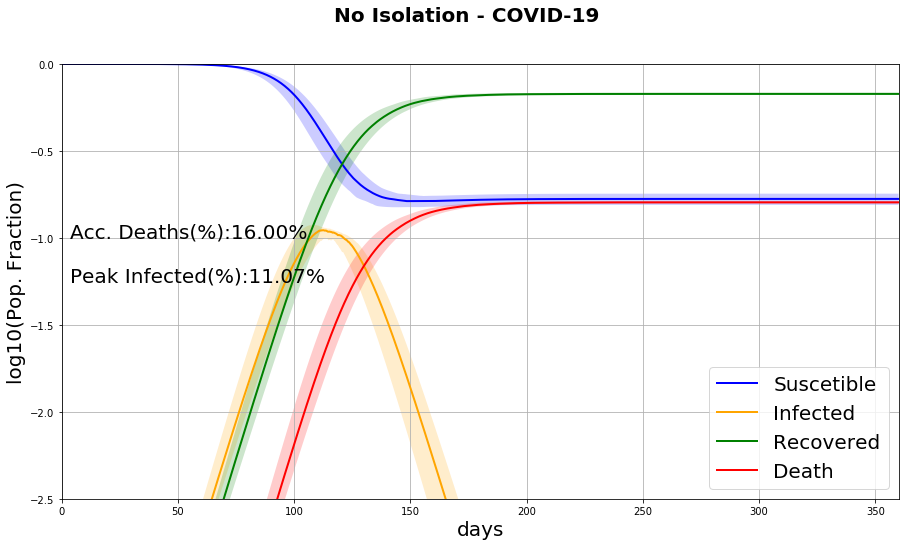

In [5]:
plot_fig_model(dic_model, 'No Isolation - COVID-19', max(t) + 10, 'SEIR_model_no_soc_dist.png')

The infected peak is $\sim$11% (-0.93 in log10-scale) between 100 and 125 days meanwhile the deaths reaches 16% (-0.79) of the population. 

### 2.2 - Scenario 2: Social Distancing

The social interaction in a population is denoted by the parameter $\beta$. Once we decrease it in time, it is a common and efficient way that several contries (eg. Italy, Spain, China, etc) act in order to block the COVID-19 outbreak.

The basic reproduction parameter $R_0$=$\beta/\gamma$ can be written as a function of the social distancing, 
<br/><br/>
<font size="5">
$R = [1 - (1-a^2)f] R_0 = \omega R_0$
</font>

where $a$ is the reduction of the social contact and $f$ is the fraction of the population which the social distancing is imposed. Let suppose that we reduce the social interaction by a factor $a$=0.45 (45%) promoted on f=0.5 (50%) of the population. It means that $\omega \sim 0.6$ and consequently $\beta = 0.6 \beta_0$.    

In [6]:
# Run simulation (SEIR - social distancing)

# At the 80-th day , we impose a social distancing by descreasing the beta fator by 40%.

t0 = 80.
frac_beta = 0.6

# Generate some parameter according to their uncertainties range

dic_model_soc_dist = run_simulations(param_array, init_vals, t, niter, 'step', t0, frac_beta, 0.)

100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


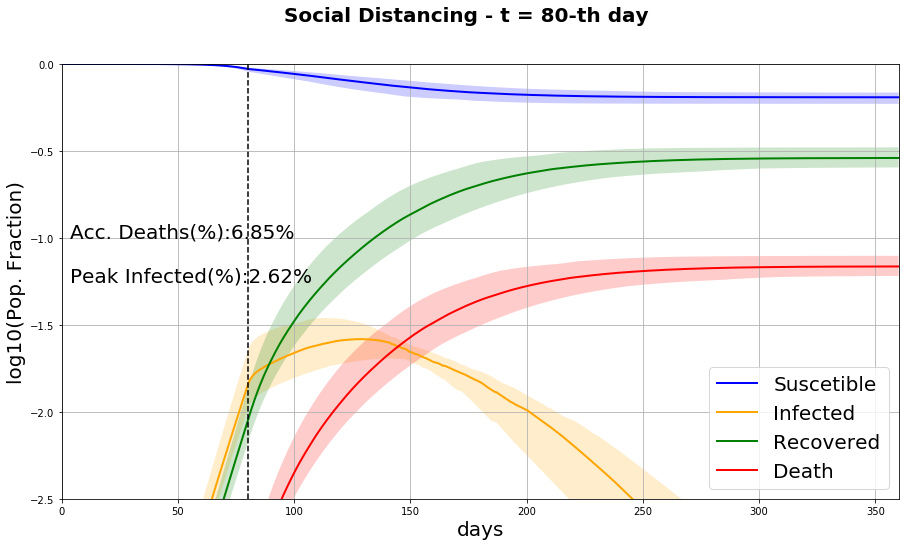

In [7]:
plot_fig_model(dic_model_soc_dist, 'Social Distancing - t = 80-th day', t0, 'SEIR_model_80_soc_dist.png')

The infected peak is $\sim$ 2.6% and deaths achieves 6.7%! Probably, the social distancing was implemented **too** late in this scenario. 

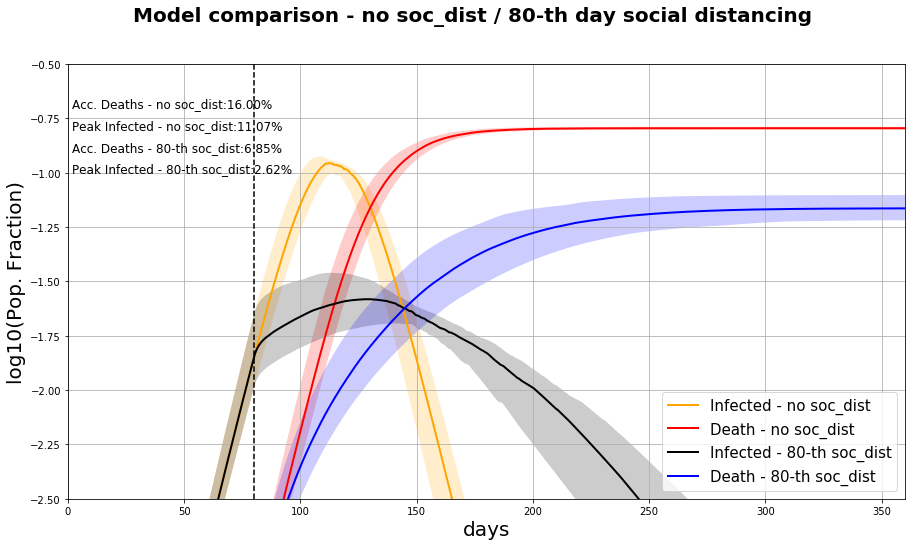

In [8]:
plot_fig_model_comparison(dic_model, dic_model_soc_dist, 
                          'Model comparison - no soc_dist / 80-th day social distancing', 
                          'no soc_dist', '80-th soc_dist', t0, frac_beta, 'SEIR_model_no_soc_dist_80_soc_dist.png')

The Figure above compares the infected and death curves for simulations with and without social distancing. The vertical dashed represents the day when the social distancing is imposed to the population.**That is why is important the social distancing to be implemented in the beginning of outbreak. The deaths is significant lower when compared to no social distancing.***

<span style="color:red">**AVOID PHYSICAL CONTACT DURING COVID 19 PANDEMIC EPISODE!**</span>

### 3 - Conclusion

The COVID 19 is a huge global problem now and the best attitude is to get social distancing as soon as possible to not overload the health system and flatten the infected curve! The COVID 19 is already a reality, then let us minimize the damage. This model shows the impact of social distancing on Infected **I(t)** and Deaths **D(t)** curves of SEIR model for the COVID 19 outbreaks. **A social distancing of at least $\sim$ 120 days is necessary to flatten the infected curve and then minimize the overload of health systems and deaths.**  

If you have any comments, suggestions or ideas to improve it, send e-mail to mvcduarte@gmail.com.

# References

* https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology
* https://arxiv.org/pdf/2002.06563.pdf
* https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296
* https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2
* https://www.researchgate.net/publication/26309995_Modeling_influenza_epidemics_and_pandemics_Insights_into_the_future_of_swine_flu_H1N1
* http://gabgoh.github.io/COVID/index.html
* https://en.wikipedia.org/wiki/Social_distancing
* https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3551767
* https://pt.wikipedia.org/wiki/Predefini%C3%A7%C3%A3o:Tabela_clim%C3%A1tica_de_S%C3%A3o_Paulo
* https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf